In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 817, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 817 (delta 184), reused 210 (delta 159), pack-reused 570
Receiving objects: 100% (817/817), 13.83 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (524/524), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 22.9 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/tuning.db
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_hyperparameter_search.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_SLIM_MSE.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2158


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': True,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/better_tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/better_tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


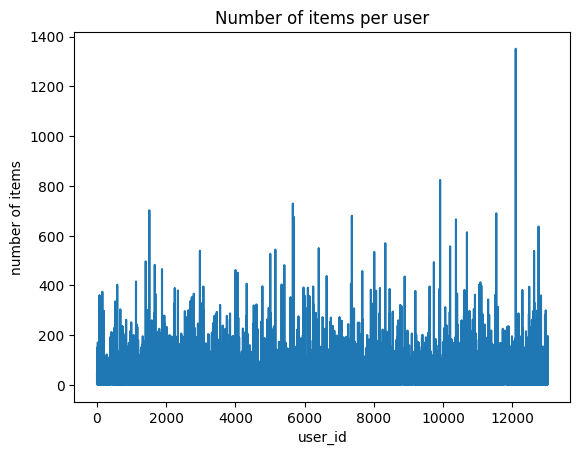

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

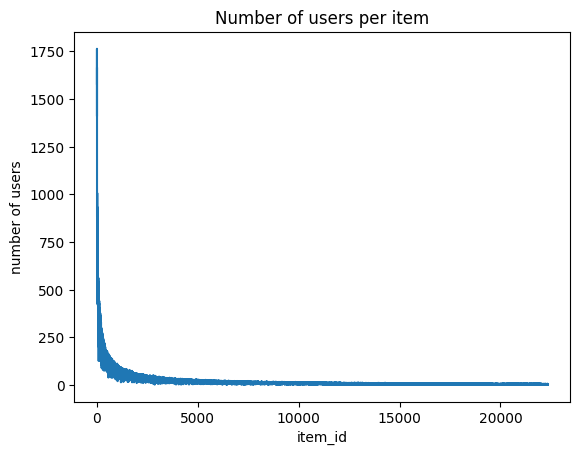

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# Hyperparameters tuning

In [24]:
import sqlite3

def print_all_rows(table_name, database_path):
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    try:
        cursor.execute(f"SELECT * FROM {table_name};")
        rows = cursor.fetchall()

        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        cursor.close()
        connection.close()

print_all_rows('studies', config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_EASE_R')


## Item KNN Collaborative Filtering

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [25]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [26]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=50)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


In [27]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [28]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [29]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [30]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [31]:
def evaluate_user_knn(URM_train, URM_valid, params):
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']

def objective_user_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_user_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user_fixed',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

[I 2023-11-26 21:35:28,772] A new study created in RDB with name: hyperparameters_tuning_knn_user_fixed


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 21:37:17,453] Trial 0 finished with value: 0.013722483872679261 and parameters: {'topK': 364, 'shrink': 215, 'similarity': 'cosine'}. Best is trial 0 with value: 0.013722483872679261.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 21:39:06,973] Trial 1 finished with value: 0.013188033566102986 and parameters: {'topK': 954, 'shrink': 50, 'similarity': 'dice'}. Best is trial 0 with value: 0.013722483872679261.


MAP is 0.01705818239710001
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1458 (11.2%) users with no interactio

[I 2023-11-26 21:40:54,282] Trial 2 finished with value: 0.013415288882184078 and parameters: {'topK': 208, 'shrink': 170, 'similarity': 'dice'}. Best is trial 0 with value: 0.013722483872679261.


UserKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 21:42:40,437] Trial 3 finished with value: 0.012771351537714156 and parameters: {'topK': 183, 'shrink': 427, 'similarity': 'cosine'}. Best is trial 0 with value: 0.013722483872679261.


MAP is 0.017512330309566053
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1460 (11.2%) users with no interacti

[I 2023-11-26 21:44:28,631] Trial 4 finished with value: 0.013818528730155202 and parameters: {'topK': 550, 'shrink': 387, 'similarity': 'dice'}. Best is trial 4 with value: 0.013818528730155202.


MAP is 0.01866056942688582
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactio

[I 2023-11-26 21:47:06,868] Trial 5 finished with value: 0.0010203639472707682 and parameters: {'topK': 137, 'shrink': 131, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'exp', 'normalize': False}. Best is trial 4 with value: 0.013818528730155202.


MAP is 0.0008797535100421818
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1417 (10.9%) users with no interact

[I 2023-11-26 21:48:56,948] Trial 6 finished with value: 0.013258130119464348 and parameters: {'topK': 900, 'shrink': 280, 'similarity': 'tanimoto'}. Best is trial 4 with value: 0.013818528730155202.


MAP is 0.017325412603742592
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1445 (11.1%) users with no interacti

[I 2023-11-26 21:50:44,106] Trial 7 finished with value: 0.013897488147621765 and parameters: {'topK': 337, 'shrink': 115, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.11709360937079105}. Best is trial 7 with value: 0.013897488147621765.


UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 21:52:31,113] Trial 8 finished with value: 0.013466872310808098 and parameters: {'topK': 249, 'shrink': 279, 'similarity': 'tanimoto'}. Best is trial 7 with value: 0.013897488147621765.


MAP is 0.018491811272531578
MAP is 0.017541950742561124
UserKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1473 (11

[I 2023-11-26 21:54:20,505] Trial 9 finished with value: 0.013348687756088672 and parameters: {'topK': 902, 'shrink': 234, 'similarity': 'tanimoto'}. Best is trial 7 with value: 0.013897488147621765.


MAP is 0.016247502188894477
MAP is 0.01766096268764712
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1449 (11.

[I 2023-11-26 21:56:08,742] Trial 10 finished with value: 0.014191982885574796 and parameters: {'topK': 603, 'shrink': 13, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.07018188364036249}. Best is trial 10 with value: 0.014191982885574796.


MAP is 0.019217204209976312
MAP is 0.01973221986362366
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1437 (11.

[I 2023-11-26 21:57:56,404] Trial 11 finished with value: 0.014312237405064519 and parameters: {'topK': 596, 'shrink': 19, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.10883419115066695}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 21:59:46,135] Trial 12 finished with value: 0.013578272653174281 and parameters: {'topK': 633, 'shrink': 3, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.020120320824657797}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.014868843451741458
MAP is 0.01825026884710936
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1454 (11.

[I 2023-11-26 22:01:34,867] Trial 13 finished with value: 0.013748296779684078 and parameters: {'topK': 718, 'shrink': 2, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01799811186144621
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1399 (10.7%) users with no interactio

[I 2023-11-26 22:03:25,406] Trial 14 finished with value: 0.013661482454354107 and parameters: {'topK': 723, 'shrink': 87, 'similarity': 'tversky', 'tversky_alpha': 0.284130437580596, 'tversky_beta': 1.4122739250432703}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018216354764992927
MAP is 0.018212539154612236
UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1370 (10

[I 2023-11-26 22:05:14,084] Trial 15 finished with value: 0.013813356579550795 and parameters: {'topK': 451, 'shrink': 52, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.8008124664036407}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01833912737334492
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactio

[I 2023-11-26 22:07:03,514] Trial 16 finished with value: 0.01220651457487148 and parameters: {'topK': 545, 'shrink': 169, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.9435668848790995}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01630182473728177
MAP is 0.016602221060008866
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.

[I 2023-11-26 22:08:51,806] Trial 17 finished with value: 0.01338548971723331 and parameters: {'topK': 774, 'shrink': 349, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.018201241461711745}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.017381644492804667
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1444 (11.1%) users with no interacti

[I 2023-11-26 22:10:38,695] Trial 18 finished with value: 0.01409555159883497 and parameters: {'topK': 436, 'shrink': 52, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:14:57,136] Trial 19 finished with value: 0.010280193912591868 and parameters: {'topK': 621, 'shrink': 165, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'log', 'normalize': True}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.010932982441446748
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1470 (11.3%) users with no interacti

[I 2023-11-26 22:16:45,831] Trial 20 finished with value: 0.013453300176846924 and parameters: {'topK': 806, 'shrink': 90, 'similarity': 'tversky', 'tversky_alpha': 1.9797300781757095, 'tversky_beta': 0.10150493212378242}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018040740682003897
MAP is 0.017581713726928197
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1461 (11

[I 2023-11-26 22:18:33,668] Trial 21 finished with value: 0.014010507305640482 and parameters: {'topK': 464, 'shrink': 46, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018870919436957106
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1422 (10.9%) users with no interacti

[I 2023-11-26 22:20:17,402] Trial 22 finished with value: 0.007653157293808515 and parameters: {'topK': 17, 'shrink': 5, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:22:02,689] Trial 23 finished with value: 0.01420325881545217 and parameters: {'topK': 381, 'shrink': 55, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.019235799612200274
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-26 22:23:48,976] Trial 24 finished with value: 0.013639977352208312 and parameters: {'topK': 344, 'shrink': 500, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.5790607423872676}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018872400238174245
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1441 (11.1%) users with no interacti

[I 2023-11-26 22:25:37,413] Trial 25 finished with value: 0.01385786573238284 and parameters: {'topK': 615, 'shrink': 87, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4006310523472567}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018021426360702072
MAP is 0.018302721088435326
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10

[I 2023-11-26 22:27:25,539] Trial 26 finished with value: 0.013853151342844053 and parameters: {'topK': 555, 'shrink': 137, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:29:11,954] Trial 27 finished with value: 0.012659700400404617 and parameters: {'topK': 672, 'shrink': 33, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.130443889102016}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01691747547153843
MAP is 0.017179026193392972
UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.

[I 2023-11-26 22:30:58,764] Trial 28 finished with value: 0.013821326129618974 and parameters: {'topK': 393, 'shrink': 93, 'similarity': 'cosine'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018468852197495327
MAP is 0.017657480558337272
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10

[I 2023-11-26 22:34:29,395] Trial 29 finished with value: 0.001209491162362392 and parameters: {'topK': 507, 'shrink': 195, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'lin', 'normalize': False}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.0016692560871096793
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interact

[I 2023-11-26 22:36:17,795] Trial 30 finished with value: 0.013810669908737316 and parameters: {'topK': 825, 'shrink': 30, 'similarity': 'tversky', 'tversky_alpha': 0.2625142271701635, 'tversky_beta': 1.9309755859782813}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018535716486631614
MAP is 0.018859983180209695
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1379 (10

[I 2023-11-26 22:38:04,025] Trial 31 finished with value: 0.014014552481579687 and parameters: {'topK': 407, 'shrink': 69, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01344612475541158
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactio

[I 2023-11-26 22:39:50,561] Trial 32 finished with value: 0.014081923639322744 and parameters: {'topK': 296, 'shrink': 40, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018973824684619865
MAP is 0.015029961043601842
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1440 (11

[I 2023-11-26 22:41:39,249] Trial 33 finished with value: 0.01412629693265811 and parameters: {'topK': 443, 'shrink': 63, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01936817743795517
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1434 (11.0%) users with no interactio

[I 2023-11-26 22:43:26,594] Trial 34 finished with value: 0.013952375031195818 and parameters: {'topK': 493, 'shrink': 116, 'similarity': 'dice'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01834804718282113
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactio

[I 2023-11-26 22:45:14,344] Trial 35 finished with value: 0.014013111313033799 and parameters: {'topK': 595, 'shrink': 27, 'similarity': 'cosine'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1475 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:46:59,867] Trial 36 finished with value: 0.014061931580333897 and parameters: {'topK': 294, 'shrink': 76, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.016895594582657984
MAP is 0.019047711424665145
UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1424 (10

[I 2023-11-26 22:48:45,528] Trial 37 finished with value: 0.012785102702141471 and parameters: {'topK': 122, 'shrink': 125, 'similarity': 'dice'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.015926788398511554
MAP is 0.018438381308207023
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1425 (10

[I 2023-11-26 22:50:32,039] Trial 38 finished with value: 0.013709203025100234 and parameters: {'topK': 527, 'shrink': 206, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4091626543637905}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.0182524225241459
UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1443 (11.1%) users with no interaction

[I 2023-11-26 22:52:19,825] Trial 39 finished with value: 0.013811236485770687 and parameters: {'topK': 375, 'shrink': 153, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.018747573054142302
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1456 (11.2%) users with no interacti

[I 2023-11-26 22:54:07,981] Trial 40 finished with value: 0.01336077402117843 and parameters: {'topK': 220, 'shrink': 266, 'similarity': 'tanimoto'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:55:55,721] Trial 41 finished with value: 0.013937203168805184 and parameters: {'topK': 408, 'shrink': 58, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1461 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:57:43,446] Trial 42 finished with value: 0.01414619376498757 and parameters: {'topK': 432, 'shrink': 20, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1429 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 22:59:30,196] Trial 43 finished with value: 0.014027367761285815 and parameters: {'topK': 572, 'shrink': 17, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.017699133559789266
UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1424 (10.9%) users with no interacti

[I 2023-11-26 23:01:17,811] Trial 44 finished with value: 0.013540809413898217 and parameters: {'topK': 669, 'shrink': 334, 'similarity': 'jaccard'}. Best is trial 11 with value: 0.014312237405064519.


UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1430 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:03:04,619] Trial 45 finished with value: 0.014207994036800722 and parameters: {'topK': 322, 'shrink': 21, 'similarity': 'cosine'}. Best is trial 11 with value: 0.014312237405064519.


MAP is 0.01974421384245183
MAP is 0.01935284222553719
MAP is 0.01738405181942779
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommend

[I 2023-11-26 23:04:53,253] Trial 46 finished with value: 0.014378212511497377 and parameters: {'topK': 309, 'shrink': 18, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.020070662652193347
MAP is 0.018993448397816352
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1471 (11

[I 2023-11-26 23:06:40,923] Trial 47 finished with value: 0.013535694777299065 and parameters: {'topK': 291, 'shrink': 106, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1421 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:08:28,308] Trial 48 finished with value: 0.01422342203252617 and parameters: {'topK': 194, 'shrink': 3, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.020205796109004037
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11.2%) users with no interacti

[I 2023-11-26 23:10:16,644] Trial 49 finished with value: 0.012935494113154727 and parameters: {'topK': 92, 'shrink': 7, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.018755684350922425
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1410 (10.8%) users with no interacti

[I 2023-11-26 23:12:02,964] Trial 50 finished with value: 0.014066655493633687 and parameters: {'topK': 210, 'shrink': 0, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1391 (10.7%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:13:47,635] Trial 51 finished with value: 0.01357279135524225 and parameters: {'topK': 169, 'shrink': 35, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:15:27,668] Trial 52 finished with value: 0.013843502618620718 and parameters: {'topK': 255, 'shrink': 49, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.014596969392910294
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interacti

[I 2023-11-26 23:17:13,844] Trial 53 finished with value: 0.01424828928733495 and parameters: {'topK': 343, 'shrink': 22, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:19:00,742] Trial 54 finished with value: 0.013866588936498078 and parameters: {'topK': 333, 'shrink': 71, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:20:48,396] Trial 55 finished with value: 0.01418303596220423 and parameters: {'topK': 324, 'shrink': 27, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:22:36,029] Trial 56 finished with value: 0.013544136713176946 and parameters: {'topK': 250, 'shrink': 102, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1427 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:24:23,059] Trial 57 finished with value: 0.013866195159401285 and parameters: {'topK': 177, 'shrink': 1, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.019550181220439774
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1449 (11.1%) users with no interacti

[I 2023-11-26 23:26:10,734] Trial 58 finished with value: 0.014039191616573316 and parameters: {'topK': 370, 'shrink': 49, 'similarity': 'cosine'}. Best is trial 46 with value: 0.014378212511497377.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1407 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:27:59,721] Trial 59 finished with value: 0.01307660952203942 and parameters: {'topK': 990, 'shrink': 80, 'similarity': 'tanimoto'}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.015539758860792017
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1453 (11.2%) users with no interacti

[I 2023-11-26 23:30:51,753] Trial 60 finished with value: 0.010996051293337836 and parameters: {'topK': 56, 'shrink': 19, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'log', 'normalize': True}. Best is trial 46 with value: 0.014378212511497377.


MAP is 0.004151170232702884
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1428 (11.0%) users with no interacti

[I 2023-11-26 23:32:36,930] Trial 61 finished with value: 0.014582224537569768 and parameters: {'topK': 477, 'shrink': 16, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.26043887018485035}. Best is trial 61 with value: 0.014582224537569768.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1418 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:34:22,716] Trial 62 finished with value: 0.013992710710452091 and parameters: {'topK': 491, 'shrink': 43, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.4387435619685098}. Best is trial 61 with value: 0.014582224537569768.


MAP is 0.0187222639605989
MAP is 0.016353140791560535
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.9

[I 2023-11-26 23:36:09,581] Trial 63 finished with value: 0.013616645307812458 and parameters: {'topK': 283, 'shrink': 63, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.9659305160026971}. Best is trial 61 with value: 0.014582224537569768.


MAP is 0.018304675676626803
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1462 (11.2%) users with no interacti

[I 2023-11-26 23:37:56,805] Trial 64 finished with value: 0.014096236271259319 and parameters: {'topK': 356, 'shrink': 21, 'similarity': 'tversky', 'tversky_alpha': 1.270586352964294, 'tversky_beta': 0.5294604475922923}. Best is trial 61 with value: 0.014582224537569768.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:39:44,058] Trial 65 finished with value: 0.01388507112813737 and parameters: {'topK': 227, 'shrink': 37, 'similarity': 'cosine'}. Best is trial 61 with value: 0.014582224537569768.


MAP is 0.018938425423394002
UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1459 (11.2%) users with no interacti

[I 2023-11-26 23:41:30,787] Trial 66 finished with value: 0.014175537200718624 and parameters: {'topK': 315, 'shrink': 13, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.7043671101963368}. Best is trial 61 with value: 0.014582224537569768.


MAP is 0.019120424413876264
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1419 (10.9%) users with no interacti

[I 2023-11-26 23:43:19,215] Trial 67 finished with value: 0.013671854728316704 and parameters: {'topK': 471, 'shrink': 303, 'similarity': 'cosine'}. Best is trial 61 with value: 0.014582224537569768.


MAP is 0.018299317210043322
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0%) users with no interacti

[I 2023-11-26 23:45:05,633] Trial 68 finished with value: 0.012467136033010917 and parameters: {'topK': 150, 'shrink': 474, 'similarity': 'dice'}. Best is trial 61 with value: 0.014582224537569768.


UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:46:52,730] Trial 69 finished with value: 0.013859192422558017 and parameters: {'topK': 259, 'shrink': 58, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.26986838183965867}. Best is trial 61 with value: 0.014582224537569768.


MAP is 0.019063031324936034
MAP is 0.0191294245088073
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1

[I 2023-11-26 23:50:39,337] Trial 70 finished with value: 0.011139644577172089 and parameters: {'topK': 407, 'shrink': 227, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'lin', 'normalize': True}. Best is trial 61 with value: 0.014582224537569768.


UserKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:52:28,573] Trial 71 finished with value: 0.01461343447800197 and parameters: {'topK': 653, 'shrink': 10, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.21589381743769778}. Best is trial 71 with value: 0.01461343447800197.


MAP is 0.019886780781543968
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1423 (10.9%) users with no interacti

[I 2023-11-26 23:54:17,468] Trial 72 finished with value: 0.0137605015342409 and parameters: {'topK': 725, 'shrink': 34, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.3288183582213613}. Best is trial 71 with value: 0.01461343447800197.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1420 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:56:05,810] Trial 73 finished with value: 0.014658438524848435 and parameters: {'topK': 659, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.24203186173913224}. Best is trial 73 with value: 0.014658438524848435.


UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-26 23:57:54,626] Trial 74 finished with value: 0.014539855900134239 and parameters: {'topK': 651, 'shrink': 1, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.21641257409156195}. Best is trial 73 with value: 0.014658438524848435.


CPU times: user 2h 59min 28s, sys: 1h 12min 58s, total: 4h 12min 26s
Wall time: 2h 22min 26s


In [33]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

# Alternating Least Squares

In [37]:
def objective_ials(trial):
    params = {
        'reg': trial.suggest_float('reg', 1e-7, 10, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 10),
        'num_factors': trial.suggest_int('num_factors', 5, 300),
        'confidence_scaling': trial.suggest_categorical('confidence_scaling', ['linear', 'log'])
    }
    
    if params['confidence_scaling'] == 'log':
        params['epsilon'] = trial.suggest_float('epsilon', 0.1, 10, log=True)
        
    evaluator_validation = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    early_stopping_params = {
        'epochs_min': 1,
        'stop_on_validation': True,
        'validation_every_n': 1,
        'validation_metric': 'MAP',
        'lower_validations_allowed': 15,
        'evaluator_object': evaluator_validation
    }

    recommender = IALSRecommender(URM_train)
    recommender.fit(**params, **early_stopping_params)
    
    epochs = recommender.get_early_stopping_final_epochs_dict()["epochs"]
    trial.set_user_attr("epochs", epochs) 

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

In [38]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials_no_cv',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=7)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [39]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials_v2.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials_v2.json', 
            'tuning_results/best_params_ials_v2.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json', 
        '/kaggle/working/best_params_ials_v2.json'
    )

In [43]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/better_tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [44]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [45]:
# user_ids_test.info()

In [46]:
# user_ids_test.head(5)

In [47]:
# user_ids_test['user_id'].unique()

In [48]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [49]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)